In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [0]:
import importlib
import util
importlib.reload(util)
from util import *

In [0]:
stash = {}
#with open(root+"/gandb","rb") as f:
#    stash = torch.load(stash,f)

In [0]:
loss_L2 = torch.nn.MSELoss()
def train_it(dataset, model, disc,Npast=1, Nfuture=1):
    #model = model
    learning_rate = 1e-2
    optim_model = torch.optim.Adam(model.parameters(), lr=1e-3)
    optim_disc  = torch.optim.Adam(disc.parameters(), lr=1e-3)

    Nepoch = 1000
    Nbatch = 50
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,3))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        
        # Step the discriminator
        y_pred = model(xx)+xx
        L_D = -0.5*(1.0 - disc(y_pred,xx).mean() + disc(yy,xx).mean())
        optim_disc.zero_grad()
        L_D.backward(retain_graph=True)
        optim_disc.step()
        
        # Step the model
        L_G = 0.5*(1.0 - disc(y_pred,xx).mean())
        optim_model.zero_grad()
        L_G.backward()
        optim_model.step()
        
        #yy[:,:,1:-1]
        
        if e%Nprint == Nprint-1:
            L2 = loss_L2(y_pred,yy)
            print(e, L_D.item(),L2.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss_L2(yyt,yt_pred)
            L2 = loss_L2(y_pred,yy)
            losses[e//Nsave,0] = L_D.item()
            losses[e//Nsave,1] = L2.item()
            losses[e//Nsave,2] = test_err.item()
    return losses

In [0]:
models = {"PureStencil":PureStencil,}

In [59]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    for name, cls in models.items():
        try:
            model =  stash[name]['model']
            disc =   stash[name]['disc']
            results =stash[name]['loss'] 
            print("Resuming training of ",name)
        except KeyError:
            model = cls(Nx).to(device)
            disc = ConditionalDiscriminatorConv(Nx,1).to(device)
            results = np.empty((0,3))
            print("Training new ",name)
        tr_res = train_it(dataset,model,disc)
        results = np.append(results, tr_res, axis=0)
        stash[name] = {'model':model,
                       'disc':disc,
                       'loss':results}
    with open(root+f"/gan_data_{dataname}.pkl","wb") as f:
        torch.save(stash,f)

Resuming training of  PureStencil
1939 -0.4999904930591583 2.133042289642617e-05
3879 -0.500005841255188 3.561232006177306e-05
5819 -0.500009298324585 4.3540600017877296e-05
7759 -0.5000029802322388 1.3118510651111137e-06
9699 -0.4999922811985016 1.7502974515082315e-05
11639 -0.5000028610229492 5.412322570919059e-05
13579 -0.4999919533729553 4.0395512769464403e-05
15519 -0.5000053644180298 1.2190612324047834e-05
17459 -0.49999362230300903 5.161004537512781e-06
19399 -0.5000220537185669 3.765599467442371e-05


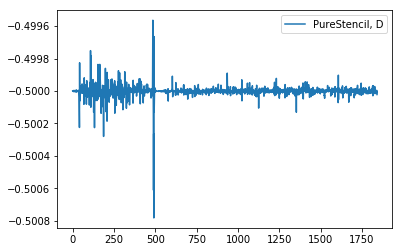

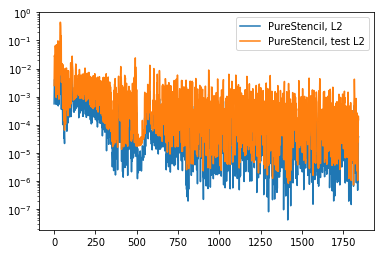

In [60]:
for N,S in stash.items():
    plt.plot(S['loss'][:,0],label=f"{N}, D")
plt.legend()
plt.show()
for N,S in stash.items():
    plt.semilogy(S['loss'][:,1],label=f"{N}, L2")
    plt.semilogy(S['loss'][:,2],label=f"{N}, test L2")
plt.legend()
plt.show()

PureStencil


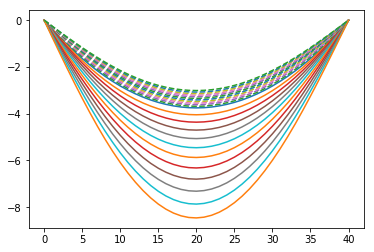

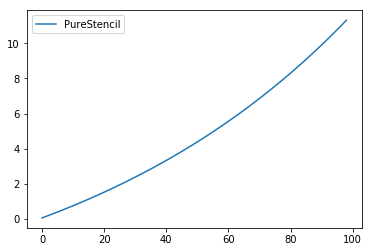

PureStencil


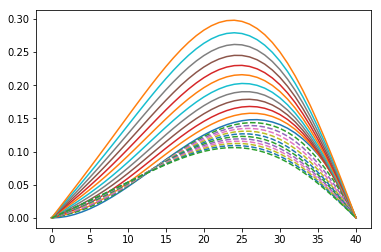

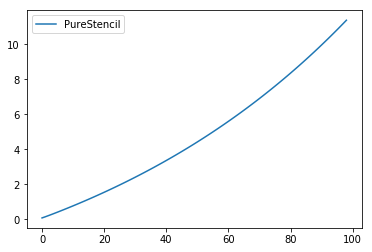

In [61]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,0)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()

In [63]:
list(stash['PureStencil']['model'].parameters())

[Parameter containing:
 tensor([[[ 0.4119, -0.8147,  0.4133]]], device='cuda:0', requires_grad=True)]

In [13]:
x.shape

NameError: ignored

In [0]:
with open(root+"/gandb","wb") as f:
    torch.save(stash,f)